In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sys
import os

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

## Dataset files

In [2]:
file_list = os.listdir('../data/netSize/')
file_list

['dataScaleFree_10_10_15_16000_B.txt',
 'dataScaleFree_5_5_15_16000_B.txt',
 'dataScaleFree_15_15_15_16000_B.txt']

## Loss Function

In [3]:
import tensorflow.keras.backend as kb
def custom_loss(y_true,y_pred):
    custom_loss=kb.mean(kb.square(y_true-y_pred))
    return custom_loss

In [4]:
neurons = [10, 25, 50, 100, 150, 225]

In [5]:
error_table = pd.DataFrame()
for i in range(3):
    nodes = (i + 1) * 5
    n2 = nodes ** 2
    file = f'../data/netSize/dataScaleFree_{nodes}_{nodes}_15_16000_B.txt'
    data = pd.read_table(file, sep=' ', header=None)
    
    X = data.iloc[:, :n2]
    y = data.iloc[:, n2:(n2 * 2)]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2 / 0.8, random_state=42)
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_val = np.array(X_val)
    y_val = np.array(y_val)

    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    this_error = []
    for n in neurons:
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(n, 
                                  input_shape=(n2,), 
                                  activation='sigmoid',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.00003)),
            tf.keras.layers.Dense(n2, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.00003))
        ])

        model.compile(optimizer='adam',
                      loss=custom_loss)

        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
        checkpoint = tf.keras.callbacks.ModelCheckpoint(
            f'../models/03.1_tf2_ann_1hl_{n2}_{n}.hdf5', monitor='val_loss', verbose=0, save_best_only=True,
            save_weights_only=False
        )

        model.fit(X_train, 
                  y_train, 
                  epochs=7500000, 
                  callbacks=[early_stop, checkpoint],
                  validation_data=(X_val, y_val),
                  verbose=0)

        test_error = custom_loss(y_test, model.predict(X_test))
        print(n, test_error)
        this_error.append(test_error.numpy())
    error_table[f'nodes_{nodes}'] = this_error

10 tf.Tensor(0.0013000575559551973, shape=(), dtype=float64)
25 tf.Tensor(0.001349745125927368, shape=(), dtype=float64)
50 tf.Tensor(0.0012290412434703764, shape=(), dtype=float64)
100 tf.Tensor(0.0013363298252221005, shape=(), dtype=float64)
150 tf.Tensor(0.0023842382563605976, shape=(), dtype=float64)
225 tf.Tensor(0.004726275669947353, shape=(), dtype=float64)
10 tf.Tensor(0.024683431393858386, shape=(), dtype=float64)
25 tf.Tensor(0.012009753121151281, shape=(), dtype=float64)
50 tf.Tensor(0.013565752749528716, shape=(), dtype=float64)
100 tf.Tensor(0.015377414518977112, shape=(), dtype=float64)
150 tf.Tensor(0.016460489644754703, shape=(), dtype=float64)
225 tf.Tensor(0.020532134329054093, shape=(), dtype=float64)
10 tf.Tensor(0.023767864141790686, shape=(), dtype=float64)
25 tf.Tensor(0.014129746722142525, shape=(), dtype=float64)
50 tf.Tensor(0.014848714623992933, shape=(), dtype=float64)
100 tf.Tensor(0.019429102851204767, shape=(), dtype=float64)
150 tf.Tensor(0.0224219377510

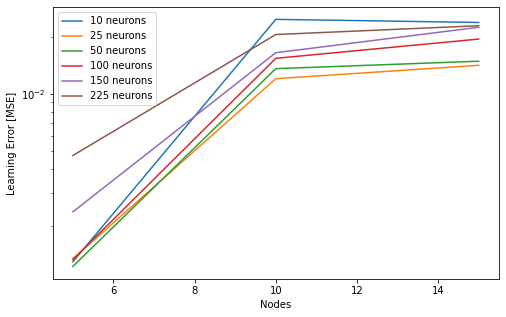

In [6]:
plt.figure(figsize=(8, 5))

plt.yscale('log')

x = [(i + 1) * 5 for i in range(3)]
for i, n in enumerate(neurons):
    y = error_table.iloc[i, :]
    plt.plot(x, y, label=f'{n} neurons')
    
plt.xlabel('Nodes')
plt.ylabel('Learning Error [MSE]')

plt.savefig('../plots/03.1_error_x_nodesneurons_1hl.png')
plt.legend()